Применим градиентный бустинг

# Импорт библиотек и данных

Launch a server via:
```bash
mlflow server --host 127.0.0.1 --port 8080
```

In [1]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import RFE, SelectKBest, f_regression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import GradientBoostingRegressor

import optuna
from optuna.trial import Trial

root_folder = '../'
sys.path.append(root_folder)

from src.models import train_model, predict_model
from src.visualization import visualize
from src.utils import get_dict

train_path = Path(root_folder, 'data', 'processed', '2.0_train.csv')
test_path = Path(root_folder, 'data', 'processed', '2.0_test.csv')

experiment_name = 'Housing cost'

random_state = 42

Загрузим датасеты:

In [2]:
train = pd.read_csv(train_path, index_col=0)
train.info()
X_train, y_train = train_model.get_X_y(train, target_name='log_target')
print()
print()

test = pd.read_csv(test_path, index_col=0)
test.info()
X_test, y_test = train_model.get_X_y(test, target_name='log_target')

<class 'pandas.core.frame.DataFrame'>
Index: 264639 entries, 0 to 264638
Data columns (total 41 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   baths                            264639 non-null  float64
 1   fireplace                        264639 non-null  bool   
 2   beds                             264639 non-null  float64
 3   stories                          264639 non-null  float64
 4   private_pool                     264639 non-null  bool   
 5   parking_count                    264639 non-null  float64
 6   central_heating                  264639 non-null  bool   
 7   central_cooling                  264639 non-null  bool   
 8   log_target                       264639 non-null  float64
 9   log_sqft                         264639 non-null  float64
 10  log_lotsize                      264639 non-null  float64
 11  updated_years                    264639 non-null  float64
 12  school_

## Pure GradientBoostingRegressor

GradientBoostingRegressor, как и другие модели на деревьях решений не требует масштабирования признаков. Также не будем создавать полиномиальные признаки.

Сначала идёт `SimpleImputer` на случай, если при использовании этой модели попадутся NaN-ы.
Сейчас пропусков нет.

В конце - модель GradientBoostingRegressor.

In [3]:
# selector_params = get_dict(
#     score_func=f_regression,
#     k=15,
# )

imputer_params = get_dict(
    missing_values=np.nan,
    strategy='median'
)

gb_params = get_dict(
    loss='squared_error',
    learning_rate=0.1,
    n_estimators=200,
    max_depth=4,
    random_state=random_state,
)

pipe_elements = [
    # ('selector', SelectKBest, selector_params),
    ('imputer', SimpleImputer, imputer_params),
    ('regressor', GradientBoostingRegressor, gb_params)
]

pipe, pipe_params = train_model.make_pipeline(pipe_elements)
display(pipe)

# Conduct fitting and cross-validation metrics estimation
cv_metrics = predict_model.cross_validate_pipe(
    pipe=pipe,
    X=X_train,
    y=y_train,
    njobs=3
)

pipe.fit(X_train, y_train)
metrics = predict_model.get_train_test_metrics(
    pipe,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)
metrics = metrics | cv_metrics

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('regressor',
                 GradientBoostingRegressor(max_depth=4, n_estimators=200,
                                           random_state=42))])

,cv_train,cv_validation
mape_log,0.030,0.030
r2_log,0.648,0.641


,train,test
mape,0.423,0.428
r2,0.547,0.534


In [4]:
model_info = predict_model.log_pipe_mlflow(
    pipe_name='gradient-boosting-all',
    training_info='Gradient Boosting with all features',
    X=X_train,
    pipe=pipe,
    pipe_params=pipe_params,
    metrics=metrics,
    experiment_name=experiment_name,
)

Successfully registered model 'gradient-boosting-all'.
2024/04/25 14:01:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: gradient-boosting-all, version 1
Created version '1' of model 'gradient-boosting-all'.


## Лучшие признаки

Оценим важность признаков:

,feature,importance
8,log_sqft,0.304474
0,baths,0.165713
17,state_CA,0.074563
27,property_type_land/mobile,0.072804
10,updated_years,0.057365
14,median_school_rating,0.045774
20,state_NY,0.043964
26,property_type_condo,0.037418
21,state_OH,0.027631
11,school_count,0.020848


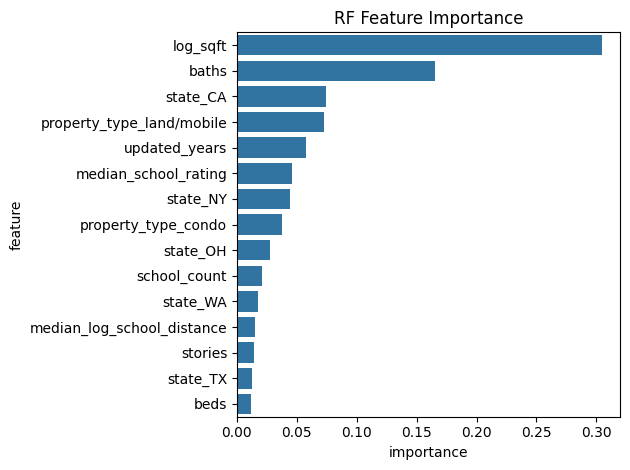

In [5]:
feature_importances = pd.DataFrame(
    {
        'feature': pipe[-2].get_feature_names_out(),
        'importance': pipe[-1].feature_importances_, 
    }
).sort_values(by='importance', ascending=False)

selected_feature_importances = feature_importances.iloc[:15]

display(selected_feature_importances)
visualize.plot_bar(
    selected_feature_importances,
    numeric_feature='importance',
    categorical_feature='feature',
    title='RF Feature Importance',
);

Также посмотрим на лучшие признаки методом f_regression

Пока не отсекаем признаки

In [6]:
selector = SelectKBest(f_regression, k=15)
selector.fit(X_train, y_train)

features_kbest = selector.get_feature_names_out()
display(features_kbest)

# X_train = X_train[features_kbest]
# X_train.info()

array(['baths', 'fireplace', 'beds', 'stories', 'private_pool',
       'parking_count', 'log_sqft', 'updated_years',
       'median_school_rating', 'status_foreclosure/pending', 'state_CA',
       'state_NY', 'state_OH', 'property_type_land/mobile',
       'parking_type_garage'], dtype=object)

Общие признаки методом `SelectKBest` и `RF Feature Importance`

In [7]:
common_features = set(features_kbest).intersection(
        set(selected_feature_importances['feature'])
    )
print(f'Общие признаки ({len(common_features)}):')
# common_features = list(common_features)

display(
    common_features
)

excluded_from_RF = set(features_kbest)\
    - set(selected_feature_importances['feature'])
print('Невошедшие в "RF feature importances"')
display(excluded_from_RF)

excluded_from_kbest = set(selected_feature_importances['feature'])\
    - set(features_kbest)
print('Невошедшие в "features_kbest"')
display(excluded_from_kbest)

union_features = set(features_kbest).union(
    set(selected_feature_importances['feature'])
)
union_features = list(union_features)

print(f'Отобранные признаки ({len(union_features)}):')
# common_features = list(common_features)

display(
    union_features
)

X_train_best = X_train[union_features]
print(f'X_train_best: {X_train_best.shape}')

X_test_best = X_test[union_features]
print(f'X_test_best: {X_test_best.shape}')

Общие признаки (10):


{'baths',
 'beds',
 'log_sqft',
 'median_school_rating',
 'property_type_land/mobile',
 'state_CA',
 'state_NY',
 'state_OH',
 'stories',
 'updated_years'}

Невошедшие в "RF feature importances"


{'fireplace',
 'parking_count',
 'parking_type_garage',
 'private_pool',
 'status_foreclosure/pending'}

Невошедшие в "features_kbest"


{'median_log_school_distance',
 'property_type_condo',
 'school_count',
 'state_TX',
 'state_WA'}

Отобранные признаки (20):


['updated_years',
 'fireplace',
 'state_CA',
 'parking_count',
 'median_school_rating',
 'state_NY',
 'state_OH',
 'school_count',
 'status_foreclosure/pending',
 'state_TX',
 'private_pool',
 'median_log_school_distance',
 'property_type_condo',
 'log_sqft',
 'parking_type_garage',
 'stories',
 'state_WA',
 'property_type_land/mobile',
 'baths',
 'beds']

X_train_best: (264639, 20)
X_test_best: (66160, 20)


## Оптимизиция GradientBoosting

In [9]:
%%time

imputer_params = get_dict(
    missing_values=np.nan,
    strategy='median'
)

def optuna_gb(trial:Trial):
    
    gb_params = get_dict(
        loss='squared_error',
        random_state=random_state,
        learning_rate=trial.suggest_float('learning_rate', 1e-3, 1, log=True),
        n_estimators=trial.suggest_int('n_estimators', 50, 350, step=10),
        max_depth=trial.suggest_int('max_depth', 2, 10, step=1),
    )

    pipe_elements = [
        # ('selector', SelectKBest, selector_params),
        ('imputer', SimpleImputer, imputer_params),
        ('regressor', GradientBoostingRegressor, gb_params)
    ]
    
    pipe, pipe_params = train_model.make_pipeline(pipe_elements)
    
    # Conduct fitting and cross-validation metrics estimation
    cv_metrics = predict_model.cross_validate_pipe(
        pipe=pipe,
        X=X_train_best,
        y=y_train,
        cv=3,
        scoring=(
            'neg_mean_absolute_percentage_error',
            'r2',
        ),
        njobs=3
    )
    
    return cv_metrics['cv_validation_r2_log']

# init study with maximization
study = optuna.create_study(
    study_name='GradientBoostingRegressor',
    direction='maximize'
)
# get best combination of hyperparams n_trials times
study.optimize(optuna_gb, n_trials=40)

[I 2024-04-25 14:13:18,260] A new study created in memory with name: GradientBoostingRegressor


,cv_train,cv_validation
mape_log,0.028,0.029
r2_log,0.693,0.653


[I 2024-04-25 14:14:10,345] Trial 0 finished with value: 0.6527704218610785 and parameters: {'learning_rate': 0.22769479350765484, 'n_estimators': 140, 'max_depth': 6}. Best is trial 0 with value: 0.6527704218610785.


,cv_train,cv_validation
mape_log,0.049,0.049
r2_log,0.136,0.136


[I 2024-04-25 14:14:40,453] Trial 1 finished with value: 0.13609123700879056 and parameters: {'learning_rate': 0.0019510032832147338, 'n_estimators': 120, 'max_depth': 4}. Best is trial 0 with value: 0.6527704218610785.


,cv_train,cv_validation
mape_log,0.040,0.040
r2_log,0.412,0.412


[I 2024-04-25 14:15:06,990] Trial 2 finished with value: 0.41158046947274096 and parameters: {'learning_rate': 0.014194607664324259, 'n_estimators': 210, 'max_depth': 2}. Best is trial 0 with value: 0.6527704218610785.


,cv_train,cv_validation
mape_log,0.036,0.036
r2_log,0.514,0.507


[I 2024-04-25 14:16:59,333] Trial 3 finished with value: 0.5073056794147536 and parameters: {'learning_rate': 0.0055378960187451596, 'n_estimators': 260, 'max_depth': 7}. Best is trial 0 with value: 0.6527704218610785.


,cv_train,cv_validation
mape_log,0.046,0.046
r2_log,0.225,0.225


[I 2024-04-25 14:17:19,568] Trial 4 finished with value: 0.22512553570792151 and parameters: {'learning_rate': 0.004823129151368667, 'n_estimators': 160, 'max_depth': 2}. Best is trial 0 with value: 0.6527704218610785.


,cv_train,cv_validation
mape_log,0.029,0.030
r2_log,0.676,0.648


[I 2024-04-25 14:18:35,433] Trial 5 finished with value: 0.6481117622167304 and parameters: {'learning_rate': 0.3103069222575781, 'n_estimators': 310, 'max_depth': 4}. Best is trial 0 with value: 0.6527704218610785.


,cv_train,cv_validation
mape_log,0.049,0.049
r2_log,0.125,0.125


[I 2024-04-25 14:19:09,849] Trial 6 finished with value: 0.12525903163156712 and parameters: {'learning_rate': 0.0012401442794623286, 'n_estimators': 270, 'max_depth': 2}. Best is trial 0 with value: 0.6527704218610785.


,cv_train,cv_validation
mape_log,0.035,0.035
r2_log,0.535,0.533


[I 2024-04-25 14:19:52,225] Trial 7 finished with value: 0.5325495307126863 and parameters: {'learning_rate': 0.020438952862543807, 'n_estimators': 170, 'max_depth': 4}. Best is trial 0 with value: 0.6527704218610785.


,cv_train,cv_validation
mape_log,0.048,0.048
r2_log,0.165,0.164


[I 2024-04-25 14:20:57,060] Trial 8 finished with value: 0.16354113838130602 and parameters: {'learning_rate': 0.0014071261369920905, 'n_estimators': 150, 'max_depth': 7}. Best is trial 0 with value: 0.6527704218610785.


,cv_train,cv_validation
mape_log,0.038,0.039
r2_log,0.462,0.447


[I 2024-04-25 14:24:20,260] Trial 9 finished with value: 0.446655184444217 and parameters: {'learning_rate': 0.002283531971733928, 'n_estimators': 340, 'max_depth': 10}. Best is trial 0 with value: 0.6527704218610785.


,cv_train,cv_validation
mape_log,0.024,0.029
r2_log,0.779,0.656


[I 2024-04-25 14:24:51,208] Trial 10 finished with value: 0.6560342437116764 and parameters: {'learning_rate': 0.297368954649943, 'n_estimators': 50, 'max_depth': 10}. Best is trial 10 with value: 0.6560342437116764.


,cv_train,cv_validation
mape_log,0.024,0.029
r2_log,0.768,0.660


[I 2024-04-25 14:25:22,151] Trial 11 finished with value: 0.6602095674819045 and parameters: {'learning_rate': 0.24893428870166576, 'n_estimators': 50, 'max_depth': 10}. Best is trial 11 with value: 0.6602095674819045.


,cv_train,cv_validation
mape_log,0.028,0.030
r2_log,0.700,0.645


[I 2024-04-25 14:25:53,569] Trial 12 finished with value: 0.6451467208655765 and parameters: {'learning_rate': 0.07775714104833224, 'n_estimators': 50, 'max_depth': 10}. Best is trial 11 with value: 0.6602095674819045.


,cv_train,cv_validation
mape_log,0.025,0.031
r2_log,0.754,0.604


[I 2024-04-25 14:26:18,562] Trial 13 finished with value: 0.6042584509276123 and parameters: {'learning_rate': 0.7962566648866276, 'n_estimators': 50, 'max_depth': 8}. Best is trial 11 with value: 0.6602095674819045.


,cv_train,cv_validation
mape_log,0.027,0.029
r2_log,0.712,0.657


[I 2024-04-25 14:27:08,141] Trial 14 finished with value: 0.6566992294678293 and parameters: {'learning_rate': 0.08392663901070287, 'n_estimators': 90, 'max_depth': 9}. Best is trial 11 with value: 0.6602095674819045.


,cv_train,cv_validation
mape_log,0.027,0.029
r2_log,0.707,0.654


[I 2024-04-25 14:28:03,281] Trial 15 finished with value: 0.6543634380170334 and parameters: {'learning_rate': 0.06757880082877955, 'n_estimators': 100, 'max_depth': 9}. Best is trial 11 with value: 0.6602095674819045.


,cv_train,cv_validation
mape_log,0.027,0.029
r2_log,0.706,0.655


[I 2024-04-25 14:28:53,018] Trial 16 finished with value: 0.6547387902464846 and parameters: {'learning_rate': 0.07280319506277991, 'n_estimators': 90, 'max_depth': 9}. Best is trial 11 with value: 0.6602095674819045.


,cv_train,cv_validation
mape_log,0.027,0.029
r2_log,0.712,0.658


[I 2024-04-25 14:29:37,065] Trial 17 finished with value: 0.6581540265547713 and parameters: {'learning_rate': 0.1535633462494426, 'n_estimators': 90, 'max_depth': 8}. Best is trial 11 with value: 0.6602095674819045.


,cv_train,cv_validation
mape_log,0.017,0.034
r2_log,0.881,0.505


[I 2024-04-25 14:31:18,665] Trial 18 finished with value: 0.5050215735378054 and parameters: {'learning_rate': 0.9189739431578727, 'n_estimators': 210, 'max_depth': 8}. Best is trial 11 with value: 0.6602095674819045.


,cv_train,cv_validation
mape_log,0.029,0.030
r2_log,0.664,0.641


[I 2024-04-25 14:31:51,636] Trial 19 finished with value: 0.6414677222276456 and parameters: {'learning_rate': 0.1697722843618961, 'n_estimators': 90, 'max_depth': 6}. Best is trial 11 with value: 0.6602095674819045.


,cv_train,cv_validation
mape_log,0.023,0.029
r2_log,0.801,0.639


[I 2024-04-25 14:32:49,512] Trial 20 finished with value: 0.6389212393660388 and parameters: {'learning_rate': 0.4791557415419628, 'n_estimators': 120, 'max_depth': 8}. Best is trial 11 with value: 0.6602095674819045.


,cv_train,cv_validation
mape_log,0.027,0.029
r2_log,0.717,0.658


[I 2024-04-25 14:33:33,497] Trial 21 finished with value: 0.6576037517057154 and parameters: {'learning_rate': 0.10546142352147467, 'n_estimators': 80, 'max_depth': 9}. Best is trial 11 with value: 0.6602095674819045.


,cv_train,cv_validation
mape_log,0.027,0.029
r2_log,0.722,0.659


[I 2024-04-25 14:34:11,859] Trial 22 finished with value: 0.6587139011597022 and parameters: {'learning_rate': 0.1369728965239082, 'n_estimators': 70, 'max_depth': 9}. Best is trial 11 with value: 0.6602095674819045.


,cv_train,cv_validation
mape_log,0.033,0.033
r2_log,0.592,0.581


[I 2024-04-25 14:34:42,432] Trial 23 finished with value: 0.5808447292343323 and parameters: {'learning_rate': 0.03758686977286323, 'n_estimators': 70, 'max_depth': 7}. Best is trial 11 with value: 0.6602095674819045.


,cv_train,cv_validation
mape_log,0.023,0.028
r2_log,0.787,0.669


[I 2024-04-25 14:35:54,325] Trial 24 finished with value: 0.669363452058625 and parameters: {'learning_rate': 0.13646905713781787, 'n_estimators': 120, 'max_depth': 10}. Best is trial 24 with value: 0.669363452058625.


,cv_train,cv_validation
mape_log,0.027,0.029
r2_log,0.710,0.652


[I 2024-04-25 14:37:07,011] Trial 25 finished with value: 0.651843222853569 and parameters: {'learning_rate': 0.03665769323230543, 'n_estimators': 120, 'max_depth': 10}. Best is trial 24 with value: 0.669363452058625.


,cv_train,cv_validation
mape_log,0.013,0.030
r2_log,0.929,0.607


[I 2024-04-25 14:38:54,508] Trial 26 finished with value: 0.6070648031758056 and parameters: {'learning_rate': 0.5025659493143368, 'n_estimators': 180, 'max_depth': 10}. Best is trial 24 with value: 0.669363452058625.


,cv_train,cv_validation
mape_log,0.023,0.029
r2_log,0.788,0.645


[I 2024-04-25 14:39:33,165] Trial 27 finished with value: 0.6451006419611504 and parameters: {'learning_rate': 0.4139437119776831, 'n_estimators': 70, 'max_depth': 9}. Best is trial 24 with value: 0.669363452058625.


,cv_train,cv_validation
mape_log,0.023,0.028
r2_log,0.790,0.669


[I 2024-04-25 14:40:45,220] Trial 28 finished with value: 0.6685324443059173 and parameters: {'learning_rate': 0.14479283678559046, 'n_estimators': 120, 'max_depth': 10}. Best is trial 24 with value: 0.669363452058625.


,cv_train,cv_validation
mape_log,0.019,0.028
r2_log,0.862,0.667


[I 2024-04-25 14:42:41,891] Trial 29 finished with value: 0.6674128318194077 and parameters: {'learning_rate': 0.2130243127624844, 'n_estimators': 190, 'max_depth': 10}. Best is trial 24 with value: 0.669363452058625.


,cv_train,cv_validation
mape_log,0.030,0.030
r2_log,0.660,0.633


[I 2024-04-25 14:44:34,608] Trial 30 finished with value: 0.633326997038055 and parameters: {'learning_rate': 0.020245215354303483, 'n_estimators': 230, 'max_depth': 8}. Best is trial 24 with value: 0.669363452058625.


,cv_train,cv_validation
mape_log,0.020,0.028
r2_log,0.847,0.663


[I 2024-04-25 14:46:00,944] Trial 31 finished with value: 0.6629364050821552 and parameters: {'learning_rate': 0.2491388871754759, 'n_estimators': 140, 'max_depth': 10}. Best is trial 24 with value: 0.669363452058625.


,cv_train,cv_validation
mape_log,0.020,0.028
r2_log,0.846,0.663


[I 2024-04-25 14:47:24,689] Trial 32 finished with value: 0.663444510468869 and parameters: {'learning_rate': 0.23719978410432901, 'n_estimators': 140, 'max_depth': 10}. Best is trial 24 with value: 0.669363452058625.


,cv_train,cv_validation
mape_log,0.027,0.029
r2_log,0.721,0.661


[I 2024-04-25 14:49:08,446] Trial 33 finished with value: 0.6610378698090863 and parameters: {'learning_rate': 0.04777101278425525, 'n_estimators': 190, 'max_depth': 9}. Best is trial 24 with value: 0.669363452058625.


,cv_train,cv_validation
mape_log,0.022,0.028
r2_log,0.818,0.669


[I 2024-04-25 14:50:39,283] Trial 34 finished with value: 0.6690788685713757 and parameters: {'learning_rate': 0.1760992437209461, 'n_estimators': 140, 'max_depth': 10}. Best is trial 24 with value: 0.669363452058625.


,cv_train,cv_validation
mape_log,0.030,0.031
r2_log,0.644,0.630


[I 2024-04-25 14:51:17,921] Trial 35 finished with value: 0.6301640989364551 and parameters: {'learning_rate': 0.13756147960034232, 'n_estimators': 120, 'max_depth': 5}. Best is trial 24 with value: 0.669363452058625.


,cv_train,cv_validation
mape_log,0.026,0.029
r2_log,0.735,0.665


[I 2024-04-25 14:53:27,851] Trial 36 finished with value: 0.6650436696017473 and parameters: {'learning_rate': 0.05453982360041874, 'n_estimators': 230, 'max_depth': 9}. Best is trial 24 with value: 0.669363452058625.


,cv_train,cv_validation
mape_log,0.030,0.031
r2_log,0.640,0.629


[I 2024-04-25 14:53:59,800] Trial 37 finished with value: 0.6286673532087611 and parameters: {'learning_rate': 0.5808075349393828, 'n_estimators': 160, 'max_depth': 3}. Best is trial 24 with value: 0.669363452058625.


,cv_train,cv_validation
mape_log,0.038,0.038
r2_log,0.460,0.458


[I 2024-04-25 14:55:04,730] Trial 38 finished with value: 0.4576140586982169 and parameters: {'learning_rate': 0.007266279622690605, 'n_estimators': 200, 'max_depth': 5}. Best is trial 24 with value: 0.669363452058625.


,cv_train,cv_validation
mape_log,0.028,0.029
r2_log,0.686,0.651


[I 2024-04-25 14:56:02,650] Trial 39 finished with value: 0.6513930519633401 and parameters: {'learning_rate': 0.11010698322197605, 'n_estimators': 130, 'max_depth': 7}. Best is trial 24 with value: 0.669363452058625.


CPU times: user 7.94 s, sys: 1.7 s, total: 9.64 s
Wall time: 42min 44s


Проверим подобранные параметры на тесте:

In [10]:
# return results on train
print("Best hyperparameters {}".format(study.best_params))
print("Validation R^2 score: {:.3f}".format(study.best_value))

imputer_params = get_dict(
    missing_values=np.nan,
    strategy='median'
)

gb_params = study.best_params
gb_params['random_state'] = random_state
gb_params['loss'] = 'squared_error'

pipe_elements = [
    # ('selector', SelectKBest, selector_params),
    ('imputer', SimpleImputer, imputer_params),
    ('regressor', GradientBoostingRegressor, gb_params)
]
    
pipe, pipe_params = train_model.make_pipeline(pipe_elements)
display(pipe)

# Conduct fitting and cross-validation metrics estimation
cv_metrics = predict_model.cross_validate_pipe(
    pipe=pipe,
    X=X_train,
    y=y_train,
    njobs=3
)

pipe.fit(X_train, y_train)
metrics = predict_model.get_train_test_metrics(
    pipe,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)
metrics = metrics | cv_metrics


Best hyperparameters {'learning_rate': 0.13646905713781787, 'n_estimators': 120, 'max_depth': 10}
Validation R^2 score: 0.669


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.13646905713781787,
                                           max_depth=10, n_estimators=120,
                                           random_state=42))])

,cv_train,cv_validation
mape_log,0.021,0.026
r2_log,0.828,0.718


,train,test
mape,0.284,0.358
r2,0.767,0.638


In [11]:
model_info = predict_model.log_pipe_mlflow(
    pipe_name='gradient-boosting-opt',
    training_info='Gradient Boosting optimized by optuna',
    X=X_train,
    pipe=pipe,
    pipe_params=pipe_params,
    metrics=metrics,
    experiment_name=experiment_name,
)

/home/vulf/.cache/pypoetry/virtualenvs/housing-cost-EeioB1ZZ-py3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/vulf/.cache/pypoetry/virtualenvs/housing-cost-EeioB1ZZ-py3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'gradient-boosting-opt'.
2024/04/25 15:07:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: gradient-boosting-opt,

Удалось получить наименьший процент ошибки `MAPE`, чем в бейзлайнах, регуляризации и Оптимизированного Случайного леса: $35.8$% против 36.8% на Random Forest

$R^2 = 0.638$ лучше чем на Random Forest ранее (0.610)

Продолжим обучение

In [12]:
%%time
# get best combination of hyperparams n_trials times (continuation)
study.optimize(optuna_gb, n_trials=40)

,cv_train,cv_validation
mape_log,0.020,0.028
r2_log,0.837,0.669


[I 2024-04-25 15:11:14,056] Trial 40 finished with value: 0.6687689142566758 and parameters: {'learning_rate': 0.1809971317835589, 'n_estimators': 170, 'max_depth': 10}. Best is trial 24 with value: 0.669363452058625.


,cv_train,cv_validation
mape_log,0.016,0.029
r2_log,0.901,0.640


[I 2024-04-25 15:12:57,330] Trial 41 finished with value: 0.6395190938553518 and parameters: {'learning_rate': 0.3694719406330963, 'n_estimators': 170, 'max_depth': 10}. Best is trial 24 with value: 0.669363452058625.


,cv_train,cv_validation
mape_log,0.021,0.028
r2_log,0.824,0.670


[I 2024-04-25 15:14:27,308] Trial 42 finished with value: 0.6699827372760688 and parameters: {'learning_rate': 0.1751125500856922, 'n_estimators': 150, 'max_depth': 10}. Best is trial 42 with value: 0.6699827372760688.


,cv_train,cv_validation
mape_log,0.022,0.028
r2_log,0.808,0.667


[I 2024-04-25 15:15:33,167] Trial 43 finished with value: 0.6667892877559316 and parameters: {'learning_rate': 0.1934410484104569, 'n_estimators': 110, 'max_depth': 10}. Best is trial 42 with value: 0.6699827372760688.


,cv_train,cv_validation
mape_log,0.029,0.030
r2_log,0.668,0.633


[I 2024-04-25 15:16:55,005] Trial 44 finished with value: 0.6332141729096663 and parameters: {'learning_rate': 0.02441139045428121, 'n_estimators': 150, 'max_depth': 9}. Best is trial 42 with value: 0.6699827372760688.


,cv_train,cv_validation
mape_log,0.023,0.028
r2_log,0.792,0.673


[I 2024-04-25 15:18:30,123] Trial 45 finished with value: 0.6731969814705483 and parameters: {'learning_rate': 0.10770044877305344, 'n_estimators': 160, 'max_depth': 10}. Best is trial 45 with value: 0.6731969814705483.


,cv_train,cv_validation
mape_log,0.023,0.028
r2_log,0.781,0.671


[I 2024-04-25 15:20:05,301] Trial 46 finished with value: 0.6709652303294057 and parameters: {'learning_rate': 0.09876509922255804, 'n_estimators': 160, 'max_depth': 10}. Best is trial 45 with value: 0.6731969814705483.


,cv_train,cv_validation
mape_log,0.025,0.028
r2_log,0.752,0.667


[I 2024-04-25 15:21:25,824] Trial 47 finished with value: 0.6674602958739931 and parameters: {'learning_rate': 0.11032217484216758, 'n_estimators': 150, 'max_depth': 9}. Best is trial 45 with value: 0.6731969814705483.


,cv_train,cv_validation
mape_log,0.017,0.029
r2_log,0.882,0.652


[I 2024-04-25 15:23:00,828] Trial 48 finished with value: 0.6516898159115683 and parameters: {'learning_rate': 0.3163389665051842, 'n_estimators': 160, 'max_depth': 10}. Best is trial 45 with value: 0.6731969814705483.


,cv_train,cv_validation
mape_log,0.028,0.030
r2_log,0.688,0.650


[I 2024-04-25 15:24:08,436] Trial 49 finished with value: 0.6503690665688567 and parameters: {'learning_rate': 0.057644190020973096, 'n_estimators': 140, 'max_depth': 8}. Best is trial 45 with value: 0.6731969814705483.


,cv_train,cv_validation
mape_log,0.025,0.028
r2_log,0.757,0.669


[I 2024-04-25 15:26:05,310] Trial 50 finished with value: 0.668865700433515 and parameters: {'learning_rate': 0.08285325560031077, 'n_estimators': 220, 'max_depth': 9}. Best is trial 45 with value: 0.6731969814705483.


,cv_train,cv_validation
mape_log,0.021,0.028
r2_log,0.830,0.676


[I 2024-04-25 15:28:54,926] Trial 51 finished with value: 0.6758177303718093 and parameters: {'learning_rate': 0.101030764830647, 'n_estimators': 290, 'max_depth': 10}. Best is trial 51 with value: 0.6758177303718093.


,cv_train,cv_validation
mape_log,0.021,0.028
r2_log,0.824,0.676


[I 2024-04-25 15:31:39,906] Trial 52 finished with value: 0.6761276578212293 and parameters: {'learning_rate': 0.0996292701399887, 'n_estimators': 280, 'max_depth': 10}. Best is trial 52 with value: 0.6761276578212293.


,cv_train,cv_validation
mape_log,0.021,0.028
r2_log,0.831,0.676


[I 2024-04-25 15:34:29,338] Trial 53 finished with value: 0.6761669357541275 and parameters: {'learning_rate': 0.10487908831117942, 'n_estimators': 290, 'max_depth': 10}. Best is trial 53 with value: 0.6761669357541275.


,cv_train,cv_validation
mape_log,0.023,0.028
r2_log,0.791,0.673


[I 2024-04-25 15:37:02,522] Trial 54 finished with value: 0.6733625372146008 and parameters: {'learning_rate': 0.09948429070097875, 'n_estimators': 290, 'max_depth': 9}. Best is trial 53 with value: 0.6761669357541275.


,cv_train,cv_validation
mape_log,0.026,0.029
r2_log,0.741,0.666


[I 2024-04-25 15:39:36,835] Trial 55 finished with value: 0.6662875359953518 and parameters: {'learning_rate': 0.0487737783152459, 'n_estimators': 290, 'max_depth': 9}. Best is trial 53 with value: 0.6761669357541275.


,cv_train,cv_validation
mape_log,0.023,0.028
r2_log,0.784,0.673


[I 2024-04-25 15:42:22,339] Trial 56 finished with value: 0.6731612049321302 and parameters: {'learning_rate': 0.0850730596447834, 'n_estimators': 310, 'max_depth': 9}. Best is trial 53 with value: 0.6761669357541275.


,cv_train,cv_validation
mape_log,0.028,0.029
r2_log,0.694,0.653


[I 2024-04-25 15:45:05,922] Trial 57 finished with value: 0.6534728066426511 and parameters: {'learning_rate': 0.028042974938271216, 'n_estimators': 340, 'max_depth': 8}. Best is trial 53 with value: 0.6761669357541275.


,cv_train,cv_validation
mape_log,0.024,0.028
r2_log,0.770,0.672


[I 2024-04-25 15:47:51,214] Trial 58 finished with value: 0.6718775403567335 and parameters: {'learning_rate': 0.07178456320026524, 'n_estimators': 310, 'max_depth': 9}. Best is trial 53 with value: 0.6761669357541275.


,cv_train,cv_validation
mape_log,0.029,0.030
r2_log,0.676,0.647


[I 2024-04-25 15:49:40,993] Trial 59 finished with value: 0.6467546002577168 and parameters: {'learning_rate': 0.041941886823847904, 'n_estimators': 260, 'max_depth': 7}. Best is trial 53 with value: 0.6761669357541275.


,cv_train,cv_validation
mape_log,0.030,0.031
r2_log,0.660,0.627


[I 2024-04-25 15:52:18,369] Trial 60 finished with value: 0.6272058357788618 and parameters: {'learning_rate': 0.01140698668084876, 'n_estimators': 290, 'max_depth': 9}. Best is trial 53 with value: 0.6761669357541275.


,cv_train,cv_validation
mape_log,0.024,0.028
r2_log,0.767,0.671


[I 2024-04-25 15:55:08,343] Trial 61 finished with value: 0.671363283622402 and parameters: {'learning_rate': 0.06657500929213776, 'n_estimators': 320, 'max_depth': 9}. Best is trial 53 with value: 0.6761669357541275.


,cv_train,cv_validation
mape_log,0.025,0.029
r2_log,0.749,0.668


[I 2024-04-25 15:57:25,085] Trial 62 finished with value: 0.6680483873126835 and parameters: {'learning_rate': 0.09233859204631907, 'n_estimators': 290, 'max_depth': 8}. Best is trial 53 with value: 0.6761669357541275.


,cv_train,cv_validation
mape_log,0.024,0.028
r2_log,0.771,0.672


[I 2024-04-25 16:00:24,682] Trial 63 finished with value: 0.6724474237990118 and parameters: {'learning_rate': 0.06834944104122592, 'n_estimators': 320, 'max_depth': 9}. Best is trial 53 with value: 0.6761669357541275.


,cv_train,cv_validation
mape_log,0.019,0.028
r2_log,0.859,0.676


[I 2024-04-25 16:03:56,186] Trial 64 finished with value: 0.6764007854557202 and parameters: {'learning_rate': 0.11502250633851398, 'n_estimators': 350, 'max_depth': 10}. Best is trial 64 with value: 0.6764007854557202.


,cv_train,cv_validation
mape_log,0.019,0.028
r2_log,0.858,0.677


[I 2024-04-25 16:07:28,118] Trial 65 finished with value: 0.6768964486518816 and parameters: {'learning_rate': 0.11729986039227595, 'n_estimators': 350, 'max_depth': 10}. Best is trial 65 with value: 0.6768964486518816.


,cv_train,cv_validation
mape_log,0.019,0.028
r2_log,0.862,0.676


[I 2024-04-25 16:11:00,420] Trial 66 finished with value: 0.6761620705365909 and parameters: {'learning_rate': 0.11830296046757938, 'n_estimators': 350, 'max_depth': 10}. Best is trial 65 with value: 0.6768964486518816.


,cv_train,cv_validation
mape_log,0.019,0.028
r2_log,0.865,0.677


[I 2024-04-25 16:14:33,552] Trial 67 finished with value: 0.6765566734290548 and parameters: {'learning_rate': 0.12106587246573804, 'n_estimators': 350, 'max_depth': 10}. Best is trial 65 with value: 0.6768964486518816.


,cv_train,cv_validation
mape_log,0.018,0.028
r2_log,0.866,0.676


[I 2024-04-25 16:18:04,918] Trial 68 finished with value: 0.6763322452491721 and parameters: {'learning_rate': 0.12430768453389435, 'n_estimators': 350, 'max_depth': 10}. Best is trial 65 with value: 0.6768964486518816.


,cv_train,cv_validation
mape_log,0.013,0.029
r2_log,0.934,0.653


[I 2024-04-25 16:21:35,650] Trial 69 finished with value: 0.6528739092445074 and parameters: {'learning_rate': 0.2780196190867864, 'n_estimators': 350, 'max_depth': 10}. Best is trial 65 with value: 0.6768964486518816.


,cv_train,cv_validation
mape_log,0.018,0.028
r2_log,0.868,0.675


[I 2024-04-25 16:25:07,136] Trial 70 finished with value: 0.675251959096875 and parameters: {'learning_rate': 0.12724005608392272, 'n_estimators': 350, 'max_depth': 10}. Best is trial 65 with value: 0.6768964486518816.


,cv_train,cv_validation
mape_log,0.019,0.028
r2_log,0.861,0.676


[I 2024-04-25 16:28:26,416] Trial 71 finished with value: 0.6759039460987317 and parameters: {'learning_rate': 0.12726081288038887, 'n_estimators': 330, 'max_depth': 10}. Best is trial 65 with value: 0.6768964486518816.


,cv_train,cv_validation
mape_log,0.019,0.028
r2_log,0.860,0.676


[I 2024-04-25 16:31:46,077] Trial 72 finished with value: 0.6762580414007181 and parameters: {'learning_rate': 0.12432138031485424, 'n_estimators': 330, 'max_depth': 10}. Best is trial 65 with value: 0.6768964486518816.


,cv_train,cv_validation
mape_log,0.015,0.028
r2_log,0.910,0.666


[I 2024-04-25 16:35:11,435] Trial 73 finished with value: 0.6659465450308214 and parameters: {'learning_rate': 0.20628167374149461, 'n_estimators': 340, 'max_depth': 10}. Best is trial 65 with value: 0.6768964486518816.


,cv_train,cv_validation
mape_log,0.017,0.028
r2_log,0.882,0.672


[I 2024-04-25 16:38:34,203] Trial 74 finished with value: 0.6723057525029962 and parameters: {'learning_rate': 0.15592791782993112, 'n_estimators': 330, 'max_depth': 10}. Best is trial 65 with value: 0.6768964486518816.


,cv_train,cv_validation
mape_log,0.018,0.028
r2_log,0.870,0.676


[I 2024-04-25 16:42:07,764] Trial 75 finished with value: 0.6760602479405419 and parameters: {'learning_rate': 0.13127775008022177, 'n_estimators': 350, 'max_depth': 10}. Best is trial 65 with value: 0.6768964486518816.


,cv_train,cv_validation
mape_log,0.023,0.028
r2_log,0.795,0.675


[I 2024-04-25 16:45:35,469] Trial 76 finished with value: 0.6748496800286786 and parameters: {'learning_rate': 0.05863036027704823, 'n_estimators': 340, 'max_depth': 10}. Best is trial 65 with value: 0.6768964486518816.


,cv_train,cv_validation
mape_log,0.028,0.029
r2_log,0.699,0.656


[I 2024-04-25 16:47:15,895] Trial 77 finished with value: 0.655791569137123 and parameters: {'learning_rate': 0.22558244874182934, 'n_estimators': 330, 'max_depth': 5}. Best is trial 65 with value: 0.6768964486518816.


,cv_train,cv_validation
mape_log,0.025,0.029
r2_log,0.752,0.658


[I 2024-04-25 16:49:13,800] Trial 78 finished with value: 0.6584108592743269 and parameters: {'learning_rate': 0.2999125025593164, 'n_estimators': 320, 'max_depth': 6}. Best is trial 65 with value: 0.6768964486518816.


,cv_train,cv_validation
mape_log,0.032,0.032
r2_log,0.608,0.603


[I 2024-04-25 16:50:11,703] Trial 79 finished with value: 0.6028722181360388 and parameters: {'learning_rate': 0.08174467454080861, 'n_estimators': 310, 'max_depth': 3}. Best is trial 65 with value: 0.6768964486518816.


CPU times: user 18 s, sys: 3.65 s, total: 21.6 s
Wall time: 1h 40min 44s


Best trial is 65. Let us check it

In [ ]:
{
    'learning_rate': 0.11729986039227595, 
    'n_estimators': 350, 
    'max_depth': 10,
    'random_state': random_state,
    'loss': 'squared_error'
}

In [3]:

imputer_params = get_dict(
    missing_values=np.nan,
    strategy='median'
)

gb_params = {
    'learning_rate': 0.11729986039227595, 
    'n_estimators': 350, 
    'max_depth': 10,
    'random_state': random_state,
    'loss': 'squared_error'
}

pipe_elements = [
    # ('selector', SelectKBest, selector_params),
    ('imputer', SimpleImputer, imputer_params),
    ('regressor', GradientBoostingRegressor, gb_params)
]
    
pipe, pipe_params = train_model.make_pipeline(pipe_elements)
display(pipe)

# Conduct fitting and cross-validation metrics estimation
cv_metrics = predict_model.cross_validate_pipe(
    pipe=pipe,
    X=X_train,
    y=y_train,
    njobs=3
)

pipe.fit(X_train, y_train)
metrics = predict_model.get_train_test_metrics(
    pipe,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)
metrics = metrics | cv_metrics


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.11729986039227595,
                                           max_depth=10, n_estimators=350,
                                           random_state=42))])

,cv_train,cv_validation
mape_log,0.016,0.025
r2_log,0.894,0.730


,train,test
mape,0.226,0.347
r2,0.845,0.654


In [4]:
model_info = predict_model.log_pipe_mlflow(
    pipe_name='gradient-boosting-opt',
    training_info='Gradient Boosting optimized by optuna',
    X=X_train,
    pipe=pipe,
    pipe_params=pipe_params,
    metrics=metrics,
    experiment_name=experiment_name,
)

Registered model 'gradient-boosting-opt' already exists. Creating a new version of this model...
2024/04/25 20:52:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: gradient-boosting-opt, version 2
Created version '2' of model 'gradient-boosting-opt'.


Получилась переобученная модель, но лучшая на тесте, чем остальные

Удалось получить наименьший процент ошибки `MAPE`, чем в бейзлайнах, регуляризации и Оптимизированного Случайного леса: $34.7$% против 35.8% на GradientBoosting

$R^2 = 0.654$ лучше чем на GradientBoosting ранее (0.638)